In [1]:
#load linear trpo parameters
import jsonpickle
import linear_trpo_utils

learned_parameter_theta_file_name = 'learned_parameter_theta.json'
learned_parameter_theta_dict = jsonpickle.decode(open(learned_parameter_theta_file_name).read())
vix_theta = learned_parameter_theta_dict['learned_parameter_theta']

In [2]:
import trading_vix_and_spy
import numpy as np
import pandas as pd

In [3]:
local_env = trading_vix_and_spy.trading_vix_and_spy()
local_env.seed(1)

In [4]:
local_env.index_feature_dataframe

,vix_price_adj_close,vix_adj_close,mv_ratio,days_since_5,days_since_6,days_since_7,spy_observation
0,170.080002,11.11,4.999308,7,37,170,"[224.410538, 224.215561, 224.159866, 225.94241..."
1,169.600006,10.89,4.906989,8,38,171,"[224.215561, 224.159866, 225.942413, 226.69448..."
2,164.960007,10.30,4.666771,9,39,172,"[224.159866, 225.942413, 226.694489, 226.52737..."
3,163.199997,9.90,4.520951,10,40,173,"[225.942413, 226.694489, 226.527374, 225.80317..."
4,160.000000,9.51,4.386410,11,41,174,"[226.694489, 226.527374, 225.803177, 226.22099..."
...,...,...,...,...,...,...,...
995,25.270000,16.66,4.535959,3,29,102,"[414.209991, 405.410004, 410.279999, 416.57998..."
996,24.770000,16.32,4.476456,4,30,103,"[405.410004, 410.279999, 416.579987, 415.51998..."
997,24.230000,15.97,4.416975,5,31,104,"[410.279999, 416.579987, 415.519989, 411.94000..."
998,23.870001,15.62,4.359830,6,32,105,"[416.579987, 415.519989, 411.940002, 410.85998..."


In [5]:
vix_action_history = []
vix_bounded_action_history = []
total_vix_value = []
vix_price_history = None
vix_buy_sell = []

In [6]:
full_observation = local_env.reset()

vix_observation = np.concatenate((full_observation[0:5],[full_observation[6]]))
vix_observation = np.array([e for e in vix_observation], dtype=np.float32)

vix_current_feature = linear_trpo_utils.extract_features(vix_observation,1) #1 for the output dimension

while True:
    
    vix_action = linear_trpo_utils.compute_action_distribution(vix_theta,vix_current_feature,mode = 'test')
    
    action_df = pd.DataFrame()
    action_df['0'] = [0] #don't buy or sell spy
    action_df['1'] = vix_action[0][0]#trading vix
    action_df['2'] = [1] #rebalance vix and spy. 1 means all money in vix
    
    action_array = action_df.iloc[0].tolist()
    action_array = np.reshape(action_array,(-1,))
    
    full_observation, reward, done, info = local_env.step(action_array)
    
    vix_action_history.append(vix_action[0][0])
    if vix_action[0][0] > 1:
        vix_bounded_action_history.append(1)
    elif vix_action[0][0] < 0 :
        vix_bounded_action_history.append(0)
    else:
        vix_bounded_action_history.append(vix_action[0][0])
    
    total_vix_value.append(info['total_vix_value'])
    if info['bought_vix']:
        vix_buy_sell.append(1)
    elif info['sold_vix']:
        vix_buy_sell.append(-1)
    else:
        vix_buy_sell.append(0)
    
    if done:
        vix_price_history = info['vix_price_trajectory']
        break
    
    vix_observation = np.concatenate((full_observation[0:5],[full_observation[6]]))
    vix_observation = np.array([e for e in vix_observation], dtype=np.float32)
    vix_current_feature = linear_trpo_utils.extract_features(vix_observation,1) #1 for the output dimension
    
    

In [7]:
print(len(vix_action_history))
print(len(total_vix_value))
print(len(vix_price_history))
print(len(vix_buy_sell))
print(len(vix_bounded_action_history))

101
101
101
101
101


In [8]:
import matplotlib.pyplot as plt

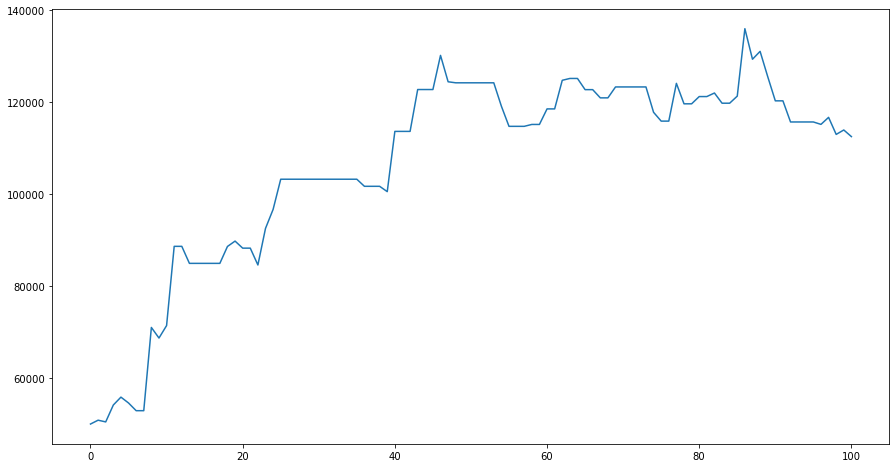

In [9]:
plt.rcParams["figure.figsize"] = (15,8)

plt.plot(total_vix_value)
plt.show()

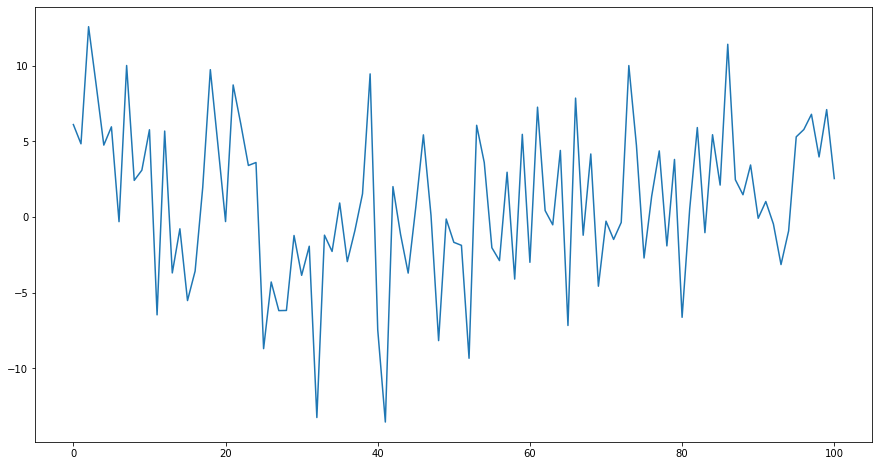

In [10]:
plt.plot(vix_action_history)
plt.show()

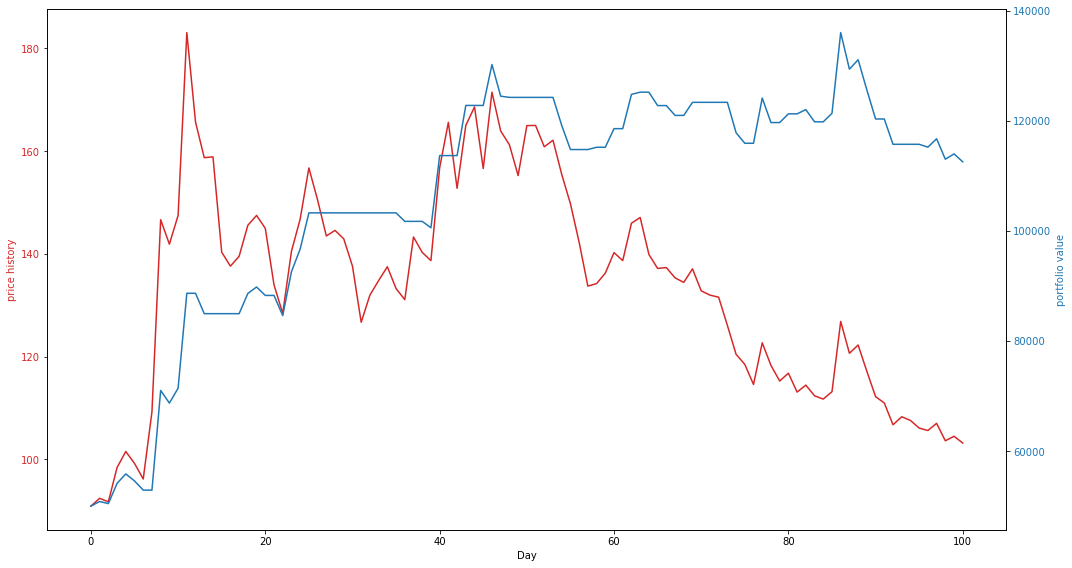

In [11]:


plt.rcParams["figure.figsize"] = (15,8)

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Day')
ax1.set_ylabel('price history', color=color)
ax1.plot(vix_price_history, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('portfolio value', color=color)  # we already handled the x-label with ax1
ax2.plot(total_vix_value, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



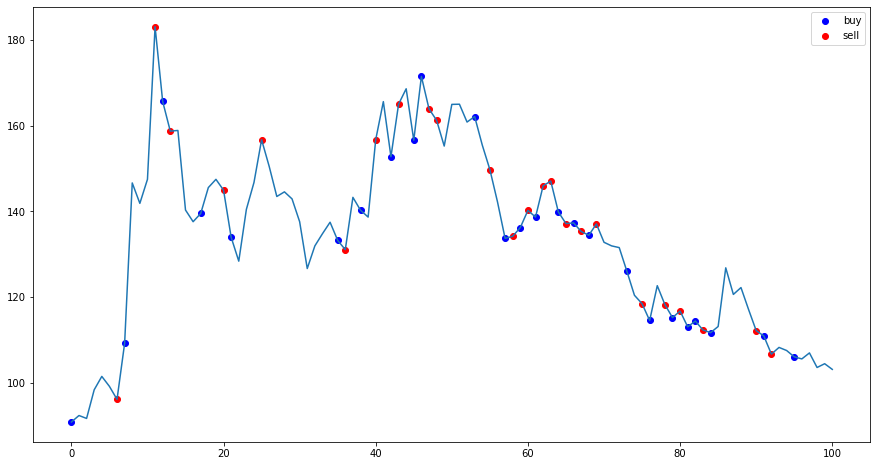

In [12]:


already_plotted_sell_legend = False
already_plotted_buy_legend = False

plt.plot(vix_price_history)
for time_index in range(0,len(vix_buy_sell)):

    if vix_buy_sell[time_index]==1:
        #print('the buy price is',price_history[time_index])
        if already_plotted_sell_legend == False:
            plt.scatter(time_index,vix_price_history[time_index],color = 'b',label = 'buy')
            already_plotted_sell_legend = True
        else:
            plt.scatter(time_index,vix_price_history[time_index],color = 'b')

    elif vix_buy_sell[time_index]==-1:
        #print('the sell price is',price_history[time_index])
        #print(' ')
        if already_plotted_buy_legend == False:
            plt.scatter(time_index,vix_price_history[time_index],color = 'r',label = 'sell')
            already_plotted_buy_legend = True
        else:
            plt.scatter(time_index,vix_price_history[time_index],color = 'r')
            
plt.legend()
plt.show()



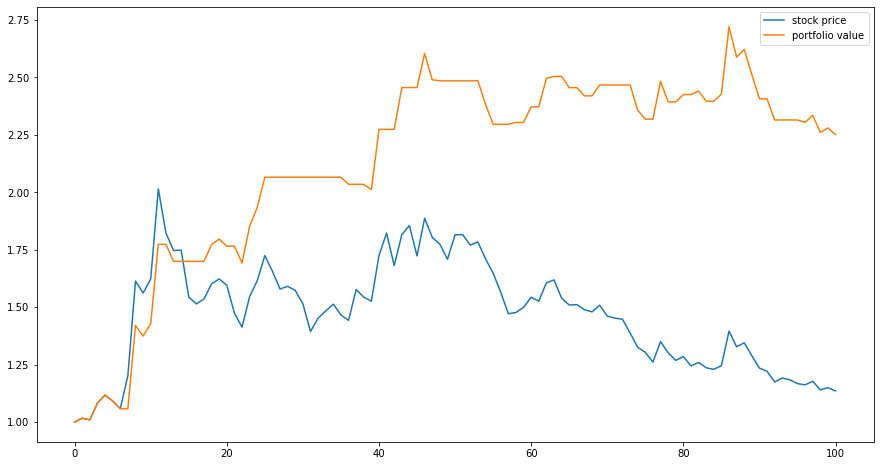

In [13]:
plt.plot(np.asarray(vix_price_history)/vix_price_history[0],label = 'stock price')
plt.plot(np.asarray(total_vix_value)/total_vix_value[0],label = 'portfolio value')
plt.legend()
plt.show()

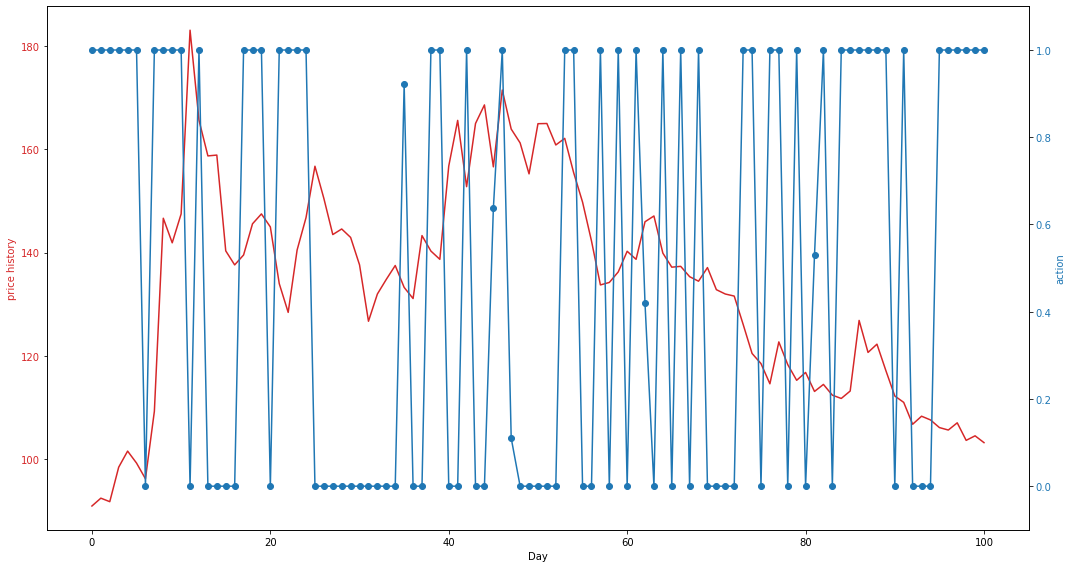

In [16]:


plt.rcParams["figure.figsize"] = (15,8)

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Day')
ax1.set_ylabel('price history', color=color)
ax1.plot(vix_price_history, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('action', color=color)  # we already handled the x-label with ax1
ax2.plot(vix_bounded_action_history,'o-',color=color)
ax2.set_ylim([-0.1,1.1])
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



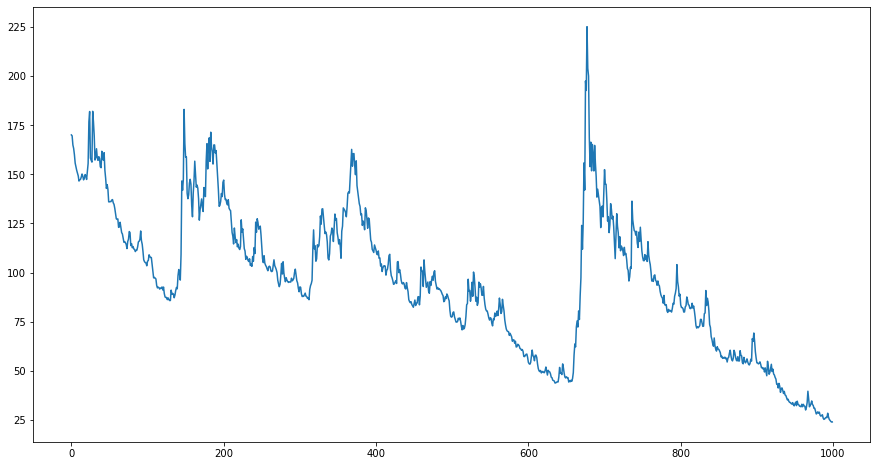

In [15]:
plt.plot(local_env.index_feature_dataframe['vix_price_adj_close'])
plt.show()